In [1]:
from tqdm import tqdm
from operator import itemgetter
from collections import OrderedDict
import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid


In [2]:
import os
import numpy as np
import pandas as pd

data = pd.read_csv('/kaggle/input/sample/sample_labels.csv')
print(data)

           Image Index                                     Finding Labels  \
0     00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1     00000013_026.png                             Cardiomegaly|Emphysema   
2     00000017_001.png                                         No Finding   
3     00000030_001.png                                        Atelectasis   
4     00000032_001.png                        Cardiomegaly|Edema|Effusion   
...                ...                                                ...   
5601  00030712_000.png                                         No Finding   
5602  00030786_005.png                    Cardiomegaly|Effusion|Emphysema   
5603  00030789_000.png                                       Infiltration   
5604  00030792_000.png                                         No Finding   
5605  00030797_000.png                                         No Finding   

      Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0

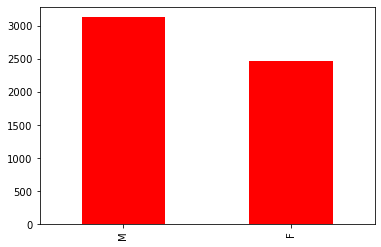

In [3]:

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

patient_counts = data['Patient Gender'].value_counts()
patient_counts.plot.bar(color='red')

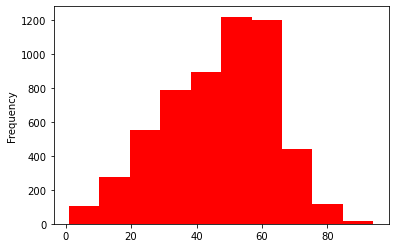

In [4]:
histogram = data['Patient Age'].apply(lambda x : int(x[1:3])).plot.hist(color='red')
histogram

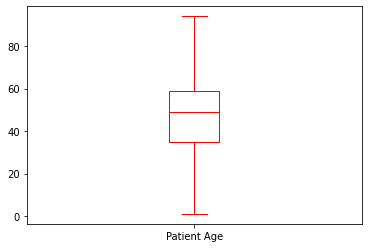

In [5]:
boxplot = data['Patient Age'].apply(lambda x : int(x[1:3])).plot.box(color='red')
boxplot

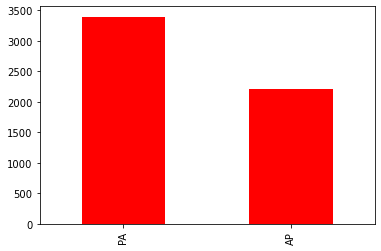

In [6]:
#Counts of the different types of xray views
viewposcount = data['View Position'].value_counts().plot.bar(color='red')
viewposcount

In [7]:
conditions = ['Effusion','Cardiomegaly','Emphysema','Hernia','Nodule','Pneumothorax','Atelectasis','Edema','Infiltration','Pleural_Thickening','Pneumonia','Mass','Consolidation','Fibrosis']

for issue in conditions :
    data[issue] = data['Finding Labels'].apply(lambda x: 1 if issue in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

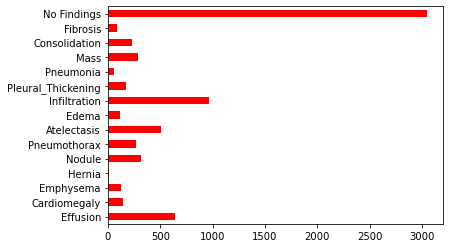

In [8]:
data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1)
valcounts_per_condition = data.iloc[:,1:].sum().plot.barh(color='red')

valcounts_per_condition

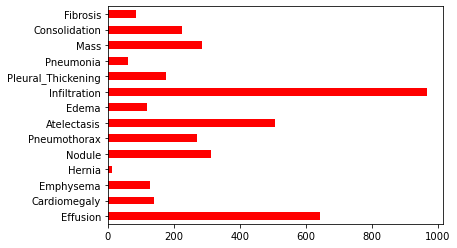

In [9]:
data = data.drop(['No Findings'],axis = 1)
data.iloc[:,1:].sum().plot.barh(color='red')


In [10]:
def calc_class_frequencies(labels):
    labels = np.array(labels)
    lenn = labels.shape[0]
    pos = np.sum(labels, axis = 0) / lenn
    neg = 1 - pos
    return pos,neg

In [11]:
freq_pos,freq_neg = calc_class_frequencies(data.iloc[:,1:])

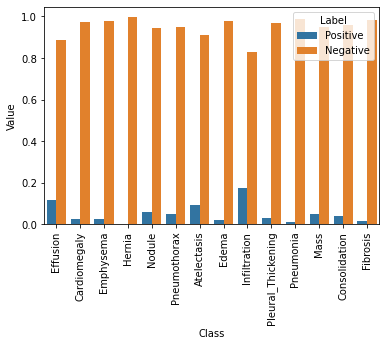

In [13]:
df = pd.DataFrame({"Class": conditions, "Label": "Positive", "Value": freq_pos})
df = df.append([{"Class": conditions[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [14]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

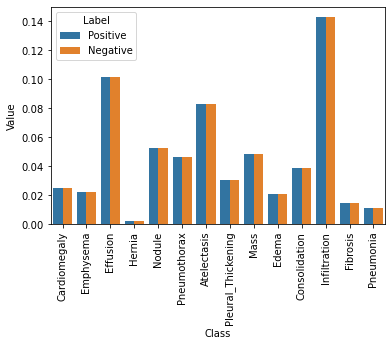

In [15]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": pos_contribution})
df = df.append([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [16]:
def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon=1e-7):
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

In [17]:
class NIH_Dataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

In [18]:
data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [19]:
trainds = NIH_Dataset(data,
                      img_dir = '/kaggle/input/sample/sample/sample/images',
                      transform = data_transform)

In [20]:
def deprocess(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

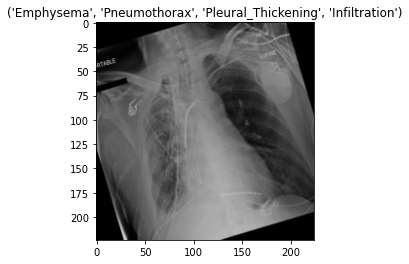

In [21]:
image, label = trainds[0]
class_labels = list(np.where(label==1)[0])
plt.imshow(deprocess(image))
plt.title(itemgetter(*class_labels)(pathology_list));

In [22]:
trainset, validset, testset = random_split(trainds, [5000,303,303])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 5000
Length of testset : 303
Length of validset : 303


In [23]:
trainloader = DataLoader(trainset,
                         batch_size = 32,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = 32,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = 32,
                        shuffle = True)

In [15]:
model = models.resnet101()
model.load_state_dict(torch.load('/kaggle/input/pretrained-model-weights-pytorch/resnet101-5d3b4d8f.pth'))

<All keys matched successfully>

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(512, 14),
    nn.Sigmoid()
)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
#Training of models
optimizer = optim.Adam(model.parameters(),
                       lr = 0.0001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.1,
                                                 patience = 4)
epochs = 15
valid_loss_min = np.Inf

In [ ]:
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 

    model.train()
    for images,labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        ps = model(images)
        loss = weighted_loss(pos_weights,neg_weights,ps,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train_loss = train_loss / len(trainloader)

    model.eval()
    with torch.no_grad():
        for images,labels in tqdm(validloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = weighted_loss(pos_weights,neg_weights,ps,labels)
            valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(validloader)

    schedular.step(avg_valid_loss)

    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save({
            'epoch' : i,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'valid_loss_min' : avg_valid_loss
        },'Pneumonia_model.pt')

        valid_loss_min = avg_valid_loss

    print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))

  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.823356).   Saving model ...
Epoch : 1 Train Loss : 0.912452 
Epoch : 1 Valid Loss : 0.823356 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.823356 --> 0.810619).   Saving model ...
Epoch : 2 Train Loss : 0.893755 
Epoch : 2 Valid Loss : 0.810619 


  0%|          | 0/157 [00:00<?, ?it/s]

Validation loss decreased (0.810619 --> 0.793737).   Saving model ...
Epoch : 3 Train Loss : 0.878702 
Epoch : 3 Valid Loss : 0.793737 


 48%|████▊     | 75/157 [01:07<01:11,  1.14it/s]

# Each Class Accuracy 

In [ ]:
def class_accuracy(dataloader, model):

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0

    with torch.no_grad():
        for images,labels in dataloader:
            ps = model(images.to(device))
            labels = labels.to(device)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df 

In [ ]:
print("Train Dataset Accuracy Report")
acc_list = class_accuracy(trainloader, model)
get_acc_data(pathology_list,acc_list)

In [ ]:
print("Test Dataset Accuracy Report")
acc_list = class_accuracy(testloader, model)
get_acc_data(pathology_list,acc_list)

In [ ]:
print("Valid Dataset Accuracy Report")
acc_list = class_accuracy(validloader, model)
get_acc_data(pathology_list,acc_list)